In [1]:
import random
from datetime import datetime

import joblib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
BATCH_SIZE = 64
RANDOM_SEED = 0
IMG_SIZE = (160, 160)
IMG_SHAPE = (160, 160, 3)
EPOCHS = 20
LEARNING_RATE = 0.0001

STARTED_TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [3]:
dataset_kwargs = {
    "label_mode": "categorical",
    "seed": RANDOM_SEED,
    "image_size": IMG_SIZE,
    "batch_size": BATCH_SIZE
}

train_dataset = tf.keras.utils.image_dataset_from_directory("../dataset/train", **dataset_kwargs)
test_dataset = tf.keras.utils.image_dataset_from_directory("../dataset/test", **dataset_kwargs)
validation_dataset = tf.keras.utils.image_dataset_from_directory("../dataset/validation", **dataset_kwargs)

class_names = train_dataset.class_names

Found 4748 files belonging to 4 classes.


2022-03-12 06:28:19.959734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 06:28:19.964903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 06:28:19.965199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 06:28:19.965746: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

Found 592 files belonging to 4 classes.
Found 592 files belonging to 4 classes.


In [4]:
# create augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomRotation(0.2),
])

# get preprocess layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [5]:
def display_dataset_sample(ds):
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(9):
            class_index = np.argmax(labels[i])
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.set_title(class_names[class_index])
            ax.axis("off")

2022-03-12 06:28:21.263452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


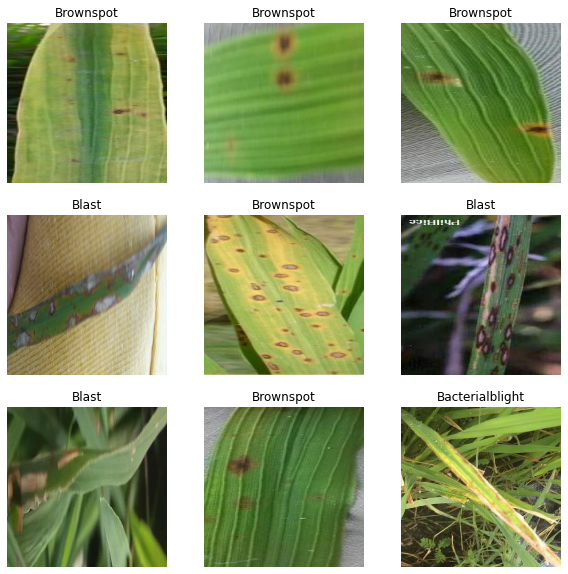

In [6]:
display_dataset_sample(train_dataset)

In [7]:
def display_augmented(ds, augmentation_model):
    for image, _ in ds.take(1):
        plt.figure(figsize=(10, 10))
        first_image = image[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = augmentation_model(tf.expand_dims(first_image, 0))
            ax.imshow(augmented_image[0] / 255)
            ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


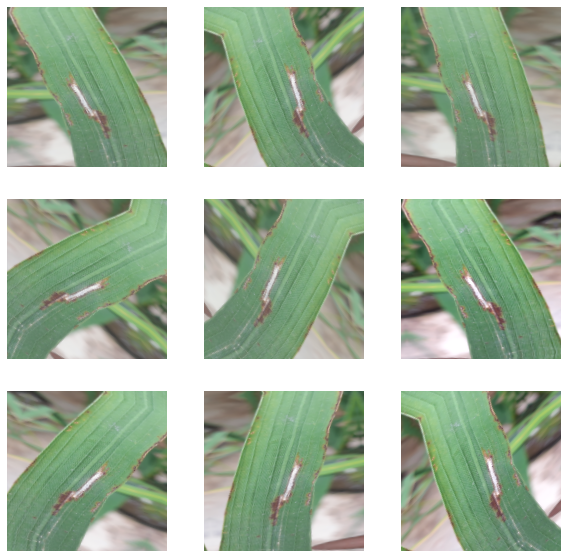

In [8]:
display_augmented(train_dataset, data_augmentation)

In [9]:
# image preprocessing
def preprocess_images(ds, augment=False, shuffle=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1024)

    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

In [10]:
# downloas base model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

In [11]:
# create final model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(base_model.input, outputs)

print("Trainable vars:", len(model.trainable_variables))

# save model structure
tf.keras.utils.plot_model(model, "../model/mobilenetv2-" + STARTED_TIMESTAMP + ".png", show_shapes=True)

# save model summary
with open("../model/summary-" + STARTED_TIMESTAMP + ".txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Trainable vars: 2


In [12]:
# define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
# evaluate model before fine tuning
loss0, accuracy0 = model.evaluate(validation_dataset)

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

2022-03-12 06:28:27.962304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-03-12 06:28:30.023384: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 06:28:30.066665: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 06:28:30.066731: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-12 06:28:30.108505: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 06:28:30.108606: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 5/10 [==============>...............] - ETA: 0s - loss: 1.9763 - accuracy: 0.2344

2022-03-12 06:28:31.925983: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 7s 83ms/step - loss: 1.9724 - accuracy: 0.2264
Initial loss: 1.97
Initial accuracy: 0.23


In [14]:
# prepare dataset for training
train_dataset = preprocess_images(train_dataset, augment=True, shuffle=True)
validation_dataset = preprocess_images(validation_dataset, augment=True, shuffle=True)

# create TensorBoard callback
tensorboard_log_dir = "./logs/mobilenet-" + STARTED_TIMESTAMP
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

# run training
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, callbacks=[tensorboard_callback])

2022-03-12 06:28:32.997782: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-12 06:28:32.997825: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-12 06:28:32.998140: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-12 06:28:33.113042: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-03-12 06:28:33.113216: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
/home/fahmi/miniconda3/envs/skripsi/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and mu

Epoch 1/20
 5/75 [=>............................] - ETA: 3s - loss: 1.7846 - accuracy: 0.3000

2022-03-12 06:28:39.336758: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-12 06:28:39.336800: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-12 06:28:39.347280: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-03-12 06:28:39.386009: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-12 06:28:39.391363: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-12 06:28:39.393205: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-12 06:28:39.396058: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/mobilenet-20220312-062819/train/plugins/pro

75/75 [==============================] - 10s 55ms/step - loss: 1.5183 - accuracy: 0.3816 - val_loss: 1.0991 - val_accuracy: 0.5321
Epoch 2/20
75/75 [==============================] - 7s 46ms/step - loss: 1.0187 - accuracy: 0.5874 - val_loss: 0.7765 - val_accuracy: 0.6959
Epoch 3/20
75/75 [==============================] - 7s 46ms/step - loss: 0.7895 - accuracy: 0.6870 - val_loss: 0.6281 - val_accuracy: 0.7551
Epoch 4/20
75/75 [==============================] - 6s 46ms/step - loss: 0.6400 - accuracy: 0.7527 - val_loss: 0.5126 - val_accuracy: 0.8193
Epoch 5/20
75/75 [==============================] - 6s 46ms/step - loss: 0.5439 - accuracy: 0.8005 - val_loss: 0.4512 - val_accuracy: 0.8480
Epoch 6/20
75/75 [==============================] - 7s 46ms/step - loss: 0.4896 - accuracy: 0.8170 - val_loss: 0.4044 - val_accuracy: 0.8598
Epoch 7/20
75/75 [==============================] - 7s 48ms/step - loss: 0.4248 - accuracy: 0.8446 - val_loss: 0.3630 - val_accuracy: 0.8733
Epoch 8/20
75/75 [=====

In [23]:
# save model
model.save("../model/mobilenet-" + STARTED_TIMESTAMP)
model.save("../model/mobilenet-" + STARTED_TIMESTAMP + ".h5")
joblib.dump(class_names, "../model/class_names-" + STARTED_TIMESTAMP + ".z")

INFO:tensorflow:Assets written to: ../model/mobilenet-20220312-062819/assets


/home/fahmi/miniconda3/envs/skripsi/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


['../model/class_names-20220312-062819.z']

In [16]:
# evaluate model after fine tuning
loss1, accuracy1 = model.evaluate(preprocess_images(test_dataset))

print("Final loss: {:.2f}".format(loss1))
print("Final accuracy: {:.2f}".format(accuracy1))

10/10 [==============================] - 1s 32ms/step - loss: 0.1857 - accuracy: 0.9392
Final loss: 0.19
Final accuracy: 0.94


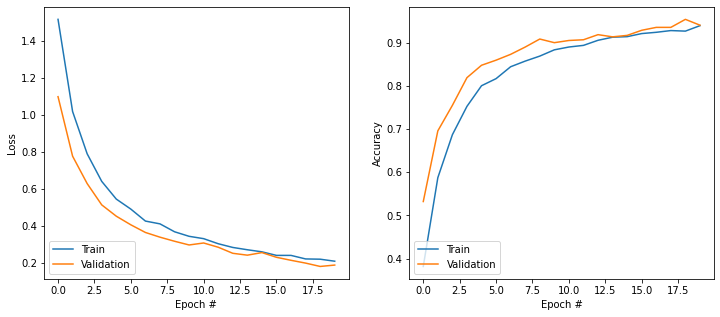

In [17]:
# Plot training & validation accuracy values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(H.history["loss"], label="Train")
ax1.plot(H.history["val_loss"], label="Validation")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend(loc="lower left")

ax2.plot(H.history["accuracy"], label="Train")
ax2.plot(H.history["val_accuracy"], label="Validation")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower left")

plt.savefig("../model/history-" + STARTED_TIMESTAMP + ".png")

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
test_dataset_preprocessed = preprocess_images(test_dataset)
for image_batch, label_batch in test_dataset_preprocessed:
   # append true labels
   y_true.append(tf.argmax(label_batch, axis=1))

   # compute predictions
   preds = tf.nn.softmax(model.predict(image_batch))
   preds = tf.argmax(preds, axis=1)

   # append predicted labels
   y_pred.append(preds)

# convert the true and predicted labels into tensors
y_true = tf.concat([item for item in y_true], axis=0).numpy()
y_pred = tf.concat([item for item in y_pred], axis=0).numpy()

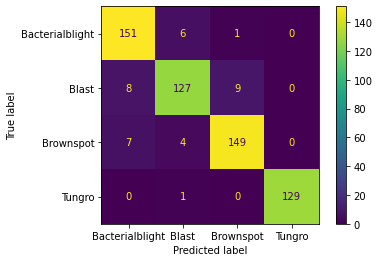

In [19]:
# create confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
plt.savefig("../model/confmatrix-" + STARTED_TIMESTAMP + ".png")

In [20]:
# print confusion matrix metrics
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

Bacterialblight       0.91      0.96      0.93       158
          Blast       0.92      0.88      0.90       144
      Brownspot       0.94      0.93      0.93       160
         Tungro       1.00      0.99      1.00       130

       accuracy                           0.94       592
      macro avg       0.94      0.94      0.94       592
   weighted avg       0.94      0.94      0.94       592



In [21]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    convLayer = model.get_layer(last_conv_layer_name).output
    grad_model = tf.keras.models.Model(
        [model.inputs], [convLayer, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

Text(0.5, 1.0, 'Predicted: Bacterialblight')

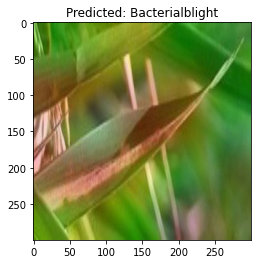

In [22]:
img_path = '../dataset/test/Bacterialblight/BACTERAILBLIGHT3_011.jpg'
#img_path = '../dataset/Blast/BLAST1_010.jpg'
#img_path = '../dataset/Brownspot/brownspot_orig_001.jpg'
#img_path = '../dataset/Tungro/TUNGRO1_004.jpg'
alpha = 0.4

pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)
pred_img = preprocess_input(pred_img)
pred_img = np.expand_dims(pred_img, axis=0)

# predict
predicted = tf.nn.softmax(model.predict(pred_img))
predicted = tf.argmax(predicted, axis=1)

# Rescale heatmap to a range 0-255
heatmap = make_gradcam_heatmap(pred_img, model, "Conv_1")
heatmap = np.uint8(255 * heatmap)

# Use RGB values of the colormap
nipy_cm = plt.cm.get_cmap("nipy_spectral")
nipy_colors = nipy_cm(np.arange(256))[:, :3]
cm_heatmap = nipy_colors[heatmap]

# load original image
original_img = tf.keras.preprocessing.image.load_img(img_path)
original_img = tf.keras.preprocessing.image.img_to_array(original_img)

# Create an image with RGB colorized heatmap
cm_heatmap = tf.keras.preprocessing.image.array_to_img(cm_heatmap)
cm_heatmap = cm_heatmap.resize((original_img.shape[1], original_img.shape[0]))
cm_heatmap = tf.keras.preprocessing.image.img_to_array(cm_heatmap)

# Superimpose the heatmap on original image
superimposed_img = cm_heatmap * alpha + original_img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
plt.imshow(superimposed_img)
plt.title("Predicted: {}".format(class_names[predicted[0]]))